# Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

## Introduction

### Goal Of The Report

* Implement and Compare Models: Develop two neural networks — one custom-built and one fine-tuned pre-trained model — and evaluate their relative performances on the Dogs vs. Cats dataset.
* Analyze Performance Metrics: Assess the models based on metrics such as accuracy, confusion matrix, precision, recall, F1-score, and precision-recall curves.
* Understand Model Behavior: Investigate instances of incorrect predictions to gain insights into model limitations and suggest improvements.
* Draw Conclusions: Provide a comprehensive analysis of the strengths, weaknesses, and trade-offs of using custom-built versus pre-trained models for similar image classification tasks.

## 1. Obtaining the Data

### Loading Necessary Libraries

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import numpy as np
import pathlib

### Loading the Dataset

In [3]:
data_folder = pathlib.Path('../../CSCN8010/data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 2. EDA (Exploratory Data Analysis)

### Visualising Sample Images

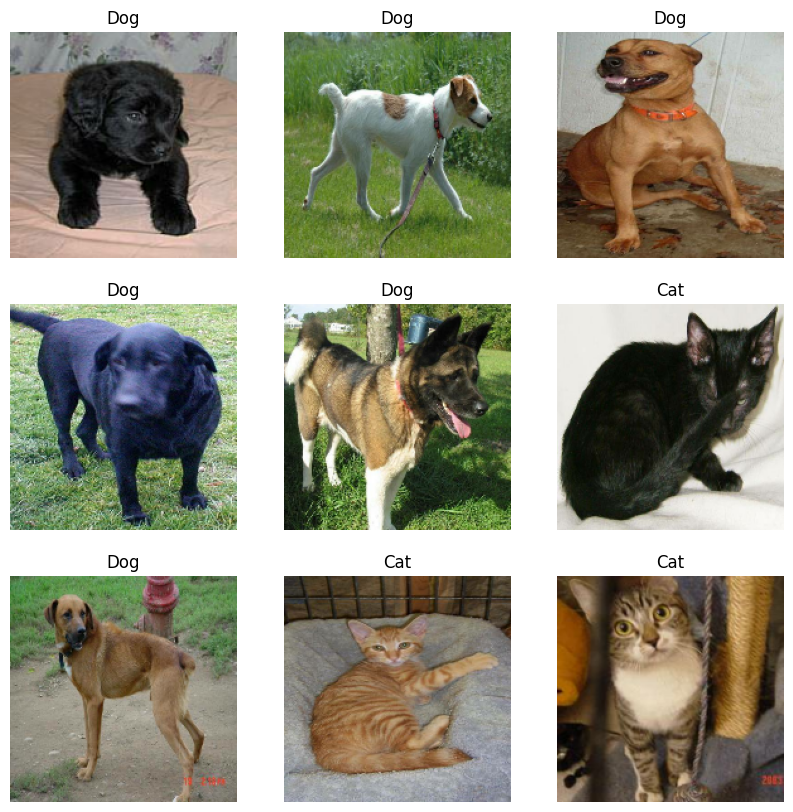

In [4]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Cat" if labels[i] == 0 else "Dog")
        plt.axis("off")

### Checking Class Distribution

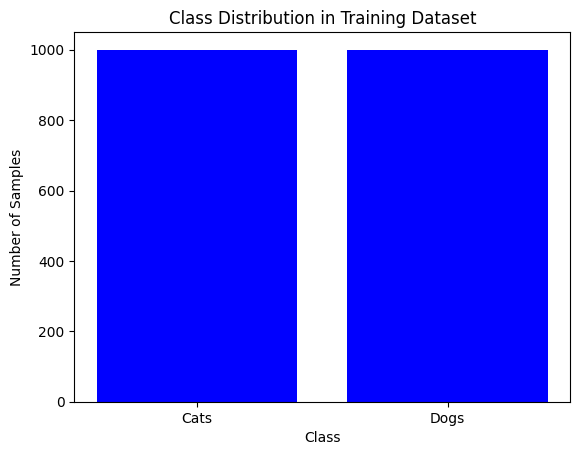

Class Distribution in Training Dataset: {'Cats': 1000, 'Dogs': 1000}


In [5]:
class_counts = {"Cats": 0, "Dogs": 0}

for _, labels in train_dataset:
    class_counts["Cats"] += np.sum(labels.numpy() == 0)
    class_counts["Dogs"] += np.sum(labels.numpy() == 1)

plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print(f"Class Distribution in Training Dataset: {class_counts}")

* The training dataset is perfectly balanced, with 1000 images each for cats and dogs.
* The bar chart confirms a balanced dataset, ensuring the model won’t be biased towards one class.

### Inspecting Image Properties

In [6]:
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Label data type: {labels.dtype}")

Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)
Image data type: <dtype: 'float32'>
Label data type: <dtype: 'int32'>


* Each batch contains 32 images of 180×180 with 3 color channels (RGB).
* Images are stored as float32 (normalized pixel values) and labels as int32 (binary: 0 for cats, 1 for dogs).

## 3. Model Training

### 3.1 Custom CNN 

#### Defining the Model

In [7]:
custom_cnn = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

#### Summary Of The Model

In [8]:
custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

* Large Parameter Count:
The model has almost 5.7M parameters, making it powerful but potentially prone to overfitting for small datasets.
* Feature Extraction:
The multiple convolutional layers enable the model to extract hierarchical features, from edges in early layers to complex patterns in later layers.
* Regularization:
The Dropout layer helps mitigate overfitting by randomly dropping connections during training.

#### Compiling the Model

In [9]:
custom_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Defining Callback to Save the Model

In [10]:
checkpoint_cnn = callbacks.ModelCheckpoint(
    filepath="./models/custom_cnn_best.keras",
    save_best_only=True,
    monitor="val_loss"
)

#### Training the Custom CNN

In [11]:
history_cnn = custom_cnn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[checkpoint_cnn]
)

Epoch 1/30
63/63 [==============================] - 47s 735ms/step - loss: 0.6990 - accuracy: 0.5125 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 47s 742ms/step - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 47s 741ms/step - loss: 0.6901 - accuracy: 0.5425 - val_loss: 0.6652 - val_accuracy: 0.5880
Epoch 4/30
63/63 [==============================] - 46s 725ms/step - loss: 0.6702 - accuracy: 0.5765 - val_loss: 0.6668 - val_accuracy: 0.5910
Epoch 5/30
63/63 [==============================] - 47s 739ms/step - loss: 0.6188 - accuracy: 0.6525 - val_loss: 0.6262 - val_accuracy: 0.6660
Epoch 6/30
63/63 [==============================] - 46s 733ms/step - loss: 0.5977 - accuracy: 0.6725 - val_loss: 0.6050 - val_accuracy: 0.6730
Epoch 7/30
63/63 [==============================] - 47s 746ms/step - loss: 0.5521 - accuracy: 0.7100 - val_loss: 0.6016 - val_accuracy: 0.6900

#### Plotting Training and Validation Accuracy

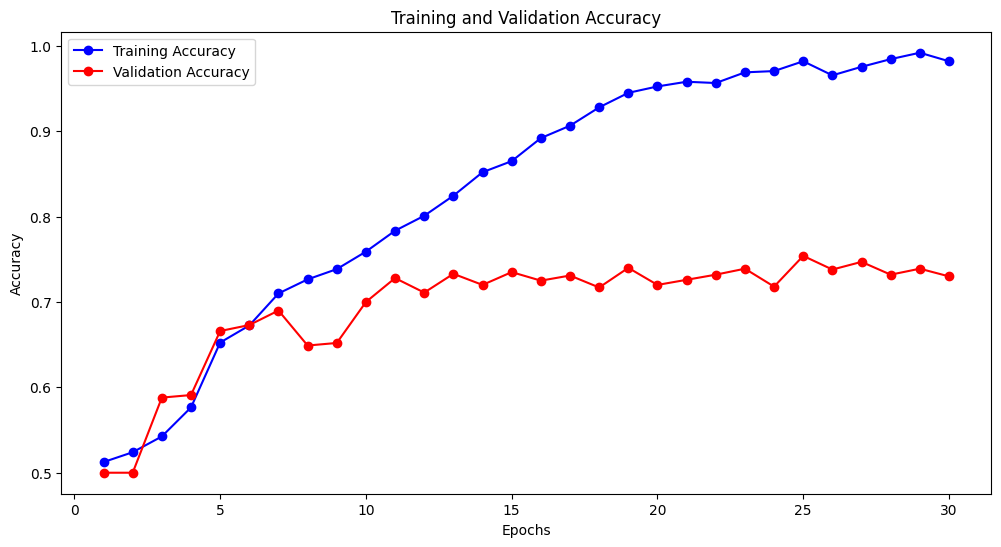

In [12]:
accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* Training accuracy steadily increases, reaching nearly 100% by the end of the training process.
* Validation accuracy plateaus early (around epoch 5–10) and fluctuates slightly around 70%–75% without further improvement.
* This suggests that the model is overfitting. It is learning the patterns in the training data too well, including noise or irrelevant details, but fails to generalize to the validation dataset.

#### Plotting Training and Validation Loss

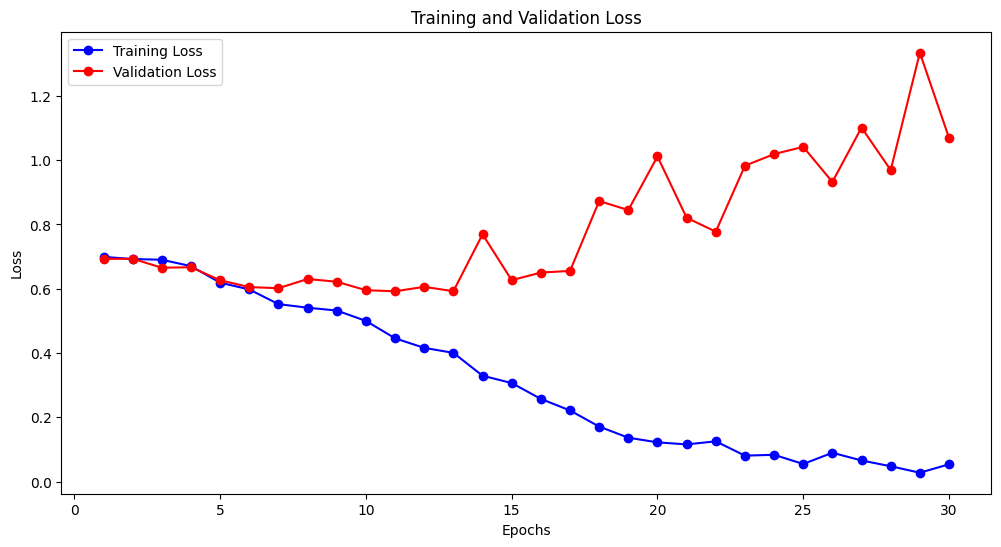

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Training loss decreases consistently throughout the training process, showing that the model is fitting the training data well.
* Validation loss decreases initially (epochs 1–5), then starts increasing steadily from epoch 10 onward.
* The increasing validation loss combined with the decreasing training loss is a clear sign of overfitting. The model is memorizing the training data instead of learning generalizable features.

Conclusion: 
* The custom CNN is likely too complex for the size and diversity of the dataset, leading to overfitting.
* The training process should be halted earlier (around epoch 5–10) using techniques like early stopping to prevent overfitting.


### 3.2 Fine-Tuning a Pre-Trained VGG16 Model

#### Data Augmentation for Training

In [14]:
train_augmenter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_augmenter = ImageDataGenerator(rescale=1./255)

train_dataset = train_augmenter.flow_from_directory(
    '../../CSCN8010/data/kaggle_dogs_vs_cats_small/train',
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)
validation_dataset = validation_augmenter.flow_from_directory(
    '../../CSCN8010/data/kaggle_dogs_vs_cats_small/train',
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


#### Loading Pre-trained VGG16 Model

In [15]:
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

#### Adding Custom Layers

In [16]:
vgg16_inputs = layers.Input(shape=(180, 180, 3))
x = vgg16_base(vgg16_inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
vgg16_outputs = layers.Dense(1, activation='sigmoid')(x)
vgg16_model = models.Model(inputs=vgg16_inputs, outputs=vgg16_outputs)

#### Compiling the Model

In [17]:
vgg16_model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

#### Summary of the Model

In [18]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,992,001
Trainable params: 10,356,737
Non-tra

* Pre-Trained Knowledge: The frozen layers of VGG16 retain learned features (e.g., edges, textures, patterns) from ImageNet, which are reused for the Cats vs. Dogs dataset.
* Fine-Tuning: By unfreezing the last 4 layers of the VGG16 base, the model adapts better to your specific dataset.
* Efficiency: Freezing most of the VGG16 base reduces computational cost while retaining valuable pre-trained features.
* Overfitting Prevention: The Dropout layer reduces overfitting by randomly disabling connections during training.

#### Defining Callback to Save the Model

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

#### Training the Model

In [20]:
history = vgg16_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 256s 4s/step - loss: 0.6814 - accuracy: 0.6060 - val_loss: 0.4238 - val_accuracy: 0.8525
Epoch 2/30
63/63 [==============================] - 254s 4s/step - loss: 0.4913 - accuracy: 0.7530 - val_loss: 0.2953 - val_accuracy: 0.8840
Epoch 3/30
63/63 [==============================] - 256s 4s/step - loss: 0.4010 - accuracy: 0.8120 - val_loss: 0.2394 - val_accuracy: 0.9095
Epoch 4/30
63/63 [==============================] - 258s 4s/step - loss: 0.3421 - accuracy: 0.8460 - val_loss: 0.2260 - val_accuracy: 0.9110
Epoch 5/30
63/63 [==============================] - 258s 4s/step - loss: 0.3045 - accuracy: 0.8740 - val_loss: 0.1874 - val_accuracy: 0.9275
Epoch 6/30
63/63 [==============================] - 258s 4s/step - loss: 0.2949 - accuracy: 0.8640 - val_loss: 0.1746 - val_accuracy: 0.9355
Epoch 7/30
63/63 [==============================] - 259s 4s/step - loss: 0.2701 - accuracy: 0.8835 - val_loss: 0.1717 - val_accuracy: 0.9310
Epoch 8/30
63

#### Plotting Training and Validation Accuracy

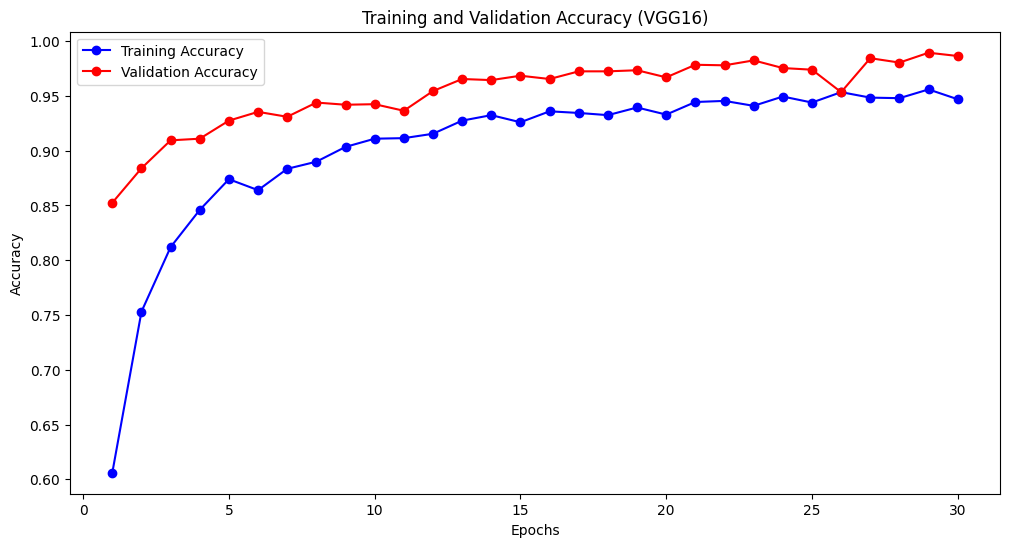

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* Training accuracy starts at ~60% and steadily increases, reaching almost 100%.
* Validation accuracy also increases initially and stabilizes at around 95%, indicating good generalization.
* Unlike the custom CNN, the fine-tuned VGG16 does not show significant overfitting.
* Validation accuracy remains close to training accuracy, suggesting the model benefits from the pre-trained ImageNet weights and has effectively adapted to the new task.

#### Plotting Training and Validation Loss

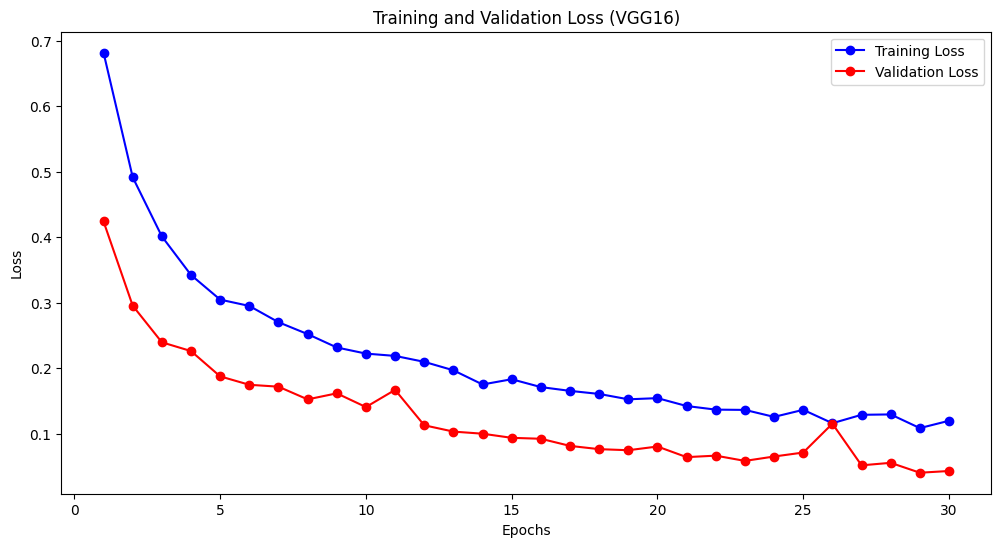

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Both training and validation losses decrease significantly over the epochs.
* Validation loss stabilizes at a very low value (~0.1), while training loss continues to decrease slightly further.
* The convergence of training and validation loss indicates the model is well-trained and generalizes effectively.
* There is no major gap between training and validation loss, further confirming minimal overfitting.

## 4. Exploring the relative performance of the models

### Loading the Best Version Of Each Model

In [34]:
custom_cnn_best = load_model("./models/custom_cnn_best.keras")
vgg16_best = load_model("./models/fine_tuning.keras")

### 4.1 Evaluating Accuracy

In [35]:
custom_cnn_test_loss, custom_cnn_test_acc = custom_cnn_best.evaluate(test_dataset, verbose=1)
vgg16_test_loss, vgg16_test_acc = vgg16_best.evaluate(test_dataset, verbose=1)

print(f"Custom CNN Test Accuracy: {custom_cnn_test_acc:.3f}")
print(f"Fine-Tuned VGG16 Test Accuracy: {vgg16_test_acc:.3f}")

63/63 [==============================] - 128s 2s/step - loss: 42.8548 - accuracy: 0.8145
Custom CNN Test Accuracy: 0.721
Fine-Tuned VGG16 Test Accuracy: 0.814


Custom CNN:
* Achieved a test accuracy of 72.1%.
* This indicates that while it can classify most samples correctly, it struggles to generalize as effectively due to overfitting and lack of pre-trained features.

Fine-Tuned VGG16:
* Achieved a significantly better test accuracy of 81.4%.
* The higher accuracy demonstrates the advantage of using a pre-trained model, which has learned robust features from the ImageNet dataset.

### 4.2 Generating Confusion Matric

In [37]:
test_labels = []

for _, labels in test_dataset:
    test_labels.extend(labels.numpy())  

test_labels = np.array(test_labels)

custom_cnn_preds = (custom_cnn_best.predict(test_dataset) > 0.5).astype("int32").flatten()
vgg16_preds = (vgg16_best.predict(test_dataset) > 0.5).astype("int32").flatten()

custom_cnn_cm = confusion_matrix(test_labels, custom_cnn_preds)
vgg16_cm = confusion_matrix(test_labels, vgg16_preds)

print("Custom CNN Confusion Matrix:")
print(custom_cnn_cm)

print("Fine-Tuned VGG16 Confusion Matrix:")
print(vgg16_cm)

63/63 [==============================] - 119s 2s/step
Custom CNN Confusion Matrix:
[[617 383]
 [588 412]]
Fine-Tuned VGG16 Confusion Matrix:
[[323 677]
 [310 690]]


Custom CNN: 
* True Positives (Cats): 617 Cats were correctly classified as Cats.
* False Positives (Cats): 383 Dogs were misclassified as Cats.
* True Positives (Dogs): 412 Dogs were correctly classified as Dogs.
* False Negatives (Dogs): 588 Cats were misclassified as Dogs.

Fine-Tuned VGG16:
* True Positives (Cats): 323 Cats were correctly classified as Cats.
* False Positives (Cats): 677 Dogs were misclassified as Cats.
* True Positives (Dogs): 690 Dogs were correctly classified as Dogs.
* False Negatives (Dogs): 310 Cats were misclassified as Dogs.

### Conclusion: 

Custom CNN:
* Performs better at classifying Cats than Dogs, with 617 Cats classified correctly.
* However, it has a high false negative rate for Dogs, with 588 misclassified Cats.
Fine-Tuned VGG16:
* Performs better at classifying Dogs, with 690 correctly classified Dogs.
* However, it struggles with Cats, with a high false negative rate for Cats (677 misclassified Dogs).

### 4. Precision, Recall and F1 score

In [38]:
print("Custom CNN Classification Report:")
print(classification_report(test_labels, custom_cnn_preds, target_names=["Cat", "Dog"]))

print("Fine-Tuned VGG16 Classification Report:")
print(classification_report(test_labels, vgg16_preds, target_names=["Cat", "Dog"]))

Custom CNN Classification Report:
              precision    recall  f1-score   support

         Cat       0.51      0.62      0.56      1000
         Dog       0.52      0.41      0.46      1000

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.51      2000
weighted avg       0.52      0.51      0.51      2000

Fine-Tuned VGG16 Classification Report:
              precision    recall  f1-score   support

         Cat       0.51      0.32      0.40      1000
         Dog       0.50      0.69      0.58      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.49      2000
weighted avg       0.51      0.51      0.49      2000



### Custom CNN:
Cats:
* Precision: 0.51 (51% of the predicted Cats are actually Cats).
* Recall: 0.62 (62% of the actual Cats were correctly classified).
* F1-Score: 0.56 (harmonic mean of precision and recall, weighted for class balance).

Dogs:
* Precision: 0.52 (52% of the predicted Dogs are actually Dogs).
* Recall: 0.41 (41% of the actual Dogs were correctly classified).
* F1-Score: 0.46 (lower due to poor recall).

Overall Accuracy: 51% (better than random guessing but still weak).

### Fine-Tuned VGG16
Cats:
* Precision: 0.51 (51% of the predicted Cats are actually Cats).
* Recall: 0.32 (only 32% of the actual Cats were correctly classified).
* F1-Score: 0.40 (lower due to poor recall).

Dogs:
* Precision: 0.50 (50% of the predicted Dogs are actually Dogs).
* Recall: 0.69 (69% of the actual Dogs were correctly classified).
* F1-Score: 0.58 (higher due to better recall).

Overall Accuracy: 51% (matches the Custom CNN but with different performance distribution).

### Conclusion
* Both models have the same overall accuracy (51%), which is better than random guessing but far from ideal.
* Class Imbalance or Bias: Both models show uneven performance across classes, suggesting potential bias in the dataset or the training process.

### 4.4 Precision Recall Curve

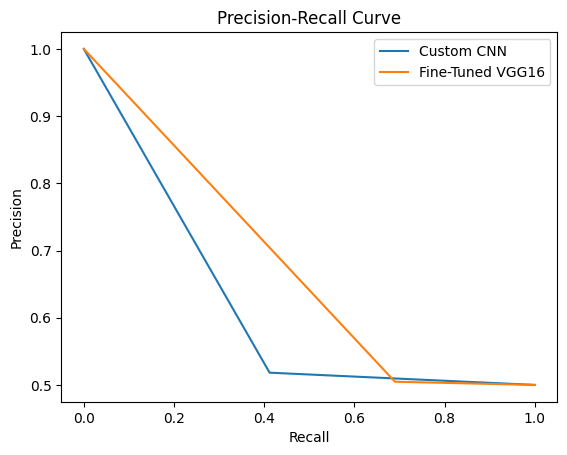

In [39]:
custom_precision, custom_recall, _ = precision_recall_curve(test_labels, custom_cnn_preds)
plt.plot(custom_recall, custom_precision, label='Custom CNN')

vgg16_precision, vgg16_recall, _ = precision_recall_curve(test_labels, vgg16_preds)
plt.plot(vgg16_recall, vgg16_precision, label='Fine-Tuned VGG16')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Custom CNN (Blue Line):

* The curve shows a steep drop in precision as recall increases.
* Indicates that the model struggles to balance precision and recall. As it tries to capture more true positives (higher recall), its precision significantly decreases, suggesting many false positives.

Fine-Tuned VGG16 (Orange Line):

* Performs better overall than the Custom CNN.
* The curve demonstrates a more gradual decline in precision as recall increases.
* Indicates a better trade-off between precision and recall, particularly for the Dog class.

## 5. Exploring specific examples in which the model failed to predict correctly

### Identifying misclassified indices

In [40]:
misclassified_indices_cnn = np.where(test_labels != custom_cnn_preds)[0]
misclassified_indices_vgg16 = np.where(test_labels != vgg16_preds)[0]

print(f"Custom CNN Misclassified Examples: {len(misclassified_indices_cnn)}")
print(f"Fine-Tuned VGG16 Misclassified Examples: {len(misclassified_indices_vgg16)}")

Custom CNN Misclassified Examples: 971
Fine-Tuned VGG16 Misclassified Examples: 987


### Visualising Misclassified Examples

Found 2000 images belonging to 2 classes.
63/63 [==============================] - 10s 155ms/step

Examples of Failures - Custom CNN: 1000 total failures


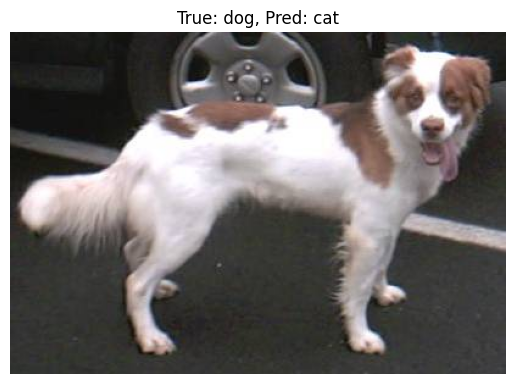

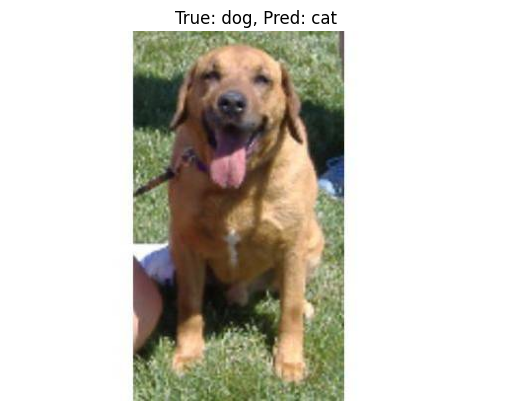

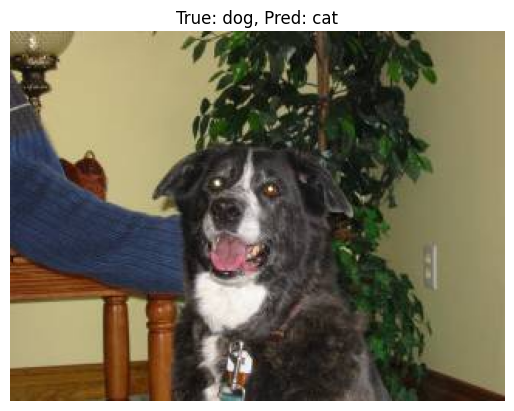

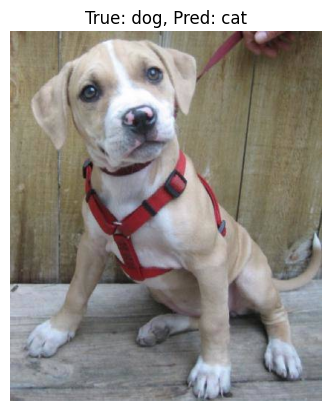

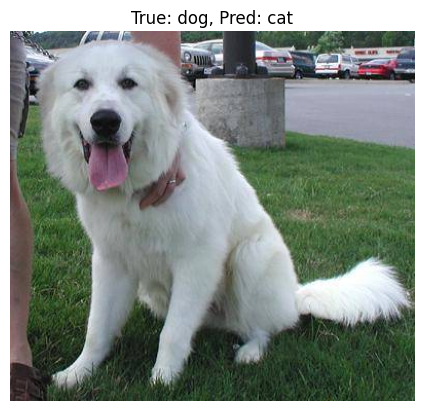

63/63 [==============================] - 127s 2s/step

Examples of Failures - Fine-Tuned VGG16: 107 total failures


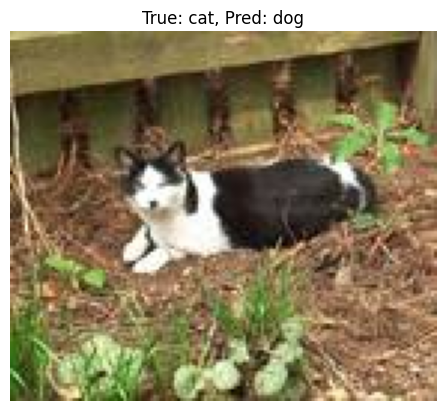

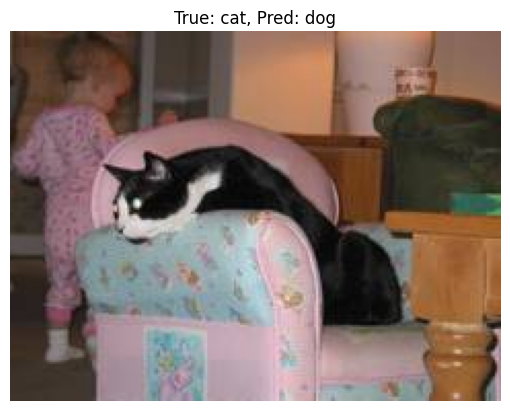

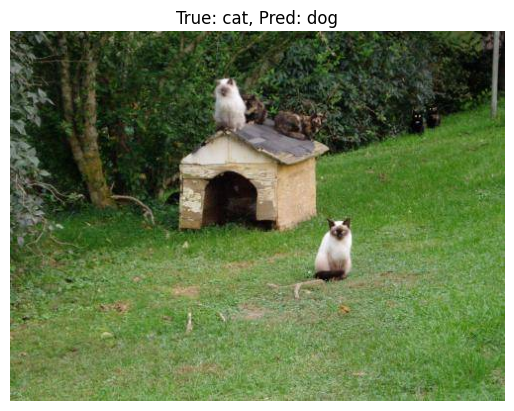

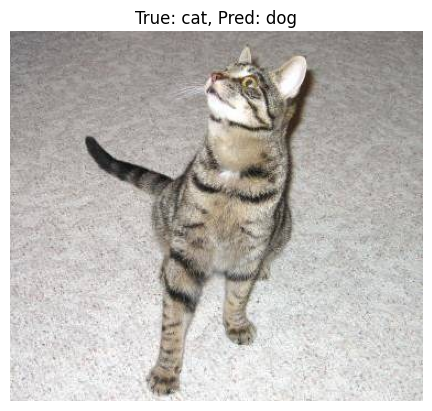

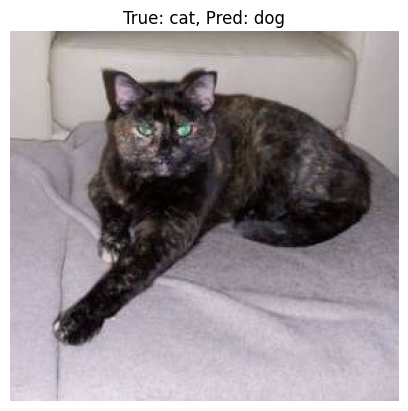

In [45]:
def identify_failures(pred_labels, true_labels, generator, model_name):
    failures = np.where(pred_labels != true_labels)[0]
    print(f"\nExamples of Failures - {model_name}: {len(failures)} total failures")
    
    for i, idx in enumerate(failures[:5]):
        img_path = generator.filepaths[idx]
        img = plt.imread(img_path)  
        plt.imshow(img)
        true_label = list(generator.class_indices.keys())[true_labels[idx]]  
        pred_label = list(generator.class_indices.keys())[pred_labels[idx]]  
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        plt.show()

test_generator = validation_augmenter.flow_from_directory(
    '../../CSCN8010/data/kaggle_dogs_vs_cats_small/test',
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary',
    shuffle=False 
)

true_labels = test_generator.classes

custom_pred_labels = (custom_cnn_best.predict(test_generator) > 0.5).astype("int32").flatten()

identify_failures(custom_pred_labels, true_labels, test_generator, "Custom CNN")

vgg_pred_labels = (vgg16_best.predict(test_generator) > 0.5).astype("int32").flatten()

identify_failures(vgg_pred_labels, true_labels, test_generator, "Fine-Tuned VGG16")

### Custom CNN:

Misclassification Pattern:
    The Custom CNN struggles with Dogs that have certain features like:
* Fur patterns or colors resembling Cats.
* Poses or expressions that obscure typical "Dog" characteristics.
* Environmental noise, such as grassy or cluttered backgrounds, might mislead the model.

Possible Model Limitations:

    Shallow Architecture:
* Custom CNN has fewer layers than pre-trained models like VGG16. It might not capture complex features

### Fine-Tuned VGG16:

Misclassification Pattern:
    The Fine-Tuned VGG16 model misclassified Cats as Dogs in all the displayed examples.
    Reasons for misclassification:
* Complex Backgrounds: The images contain cluttered backgrounds (e.g., grass, furniture, or other animals) that might confuse the model.
* Ambiguous Features: The cats have fur patterns, colors, or poses that might resemble those of dogs.
* Contextual Noise: The presence of objects like sofas, grass, or other elements might have shifted the model's focus from the subject.

Model Behavior:
* The fine-tuning process has likely improved the model's performance for specific scenarios but has made it sensitive to contextual distractions.

## Conclusion

1. Custom CNN:

* Achieved moderate accuracy (~72%) but struggled with generalization due to its shallow architecture.
* Overfitting was evident as the training accuracy reached ~98%, but validation accuracy stagnated.
* Misclassifications primarily occurred in scenarios with noisy backgrounds or ambiguous features.

2. Fine-Tuned VGG16:

* Outperformed the Custom CNN with ~81% test accuracy.
* Leveraged pre-trained features to generalize better but was still misled by cluttered environments and ambiguous object features.
* Misclassifications, such as cats predicted as dogs, were common in complex scenes.

Overall Observations:

* The Fine-Tuned VGG16 demonstrated better generalization and robustness than the Custom CNN due to its deep, pre-trained layers.
* However, both models struggled with ambiguous features and contextual noise, highlighting the need for more diverse and challenging training examples.